## Données initiales et hypothèses de calcul

### Données fournies :
- Puissance transmise : **8.5 kW**
- Vitesse de rotation : **541 rpm**
- Diamètre de l'arbre : **30 mm** (plein, cylindrique)
- Rayon engrenage B : **50 mm**
- Rayon engrenage C : **75 mm**
- Espacements : AB = 200 mm, BC = 400 mm, CD = 350 mm
- Matériau de l'arbre : **AISI 1080 CD**

### Hypothèses :
- Les engrenages sont solidaires avec l'arbre (aucune perte).
- Négligence des concentrations de contraintes.
- Négligence des contraintes dues au cisaillement transversal.
- Roulements en A et D : reprennent uniquement des forces radiales.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Puissance et dimensions initiales
P_kW = 8.5
rpm = 541
d_mm = 30
rB_mm = 50
rC_mm = 75
L_AB_mm = 200
L_BC_mm = 400
L_CD_mm = 350

# Conversion en SI
P = P_kW * 1000  # W
omega = rpm * (2 * np.pi / 60)  # rad/s
T = P / omega  # Nm
d = d_mm / 1000  # m
c = d / 2  # m
I = np.pi * d**4 / 64
J = np.pi * d**4 / 32

# Dimensions converties
rB, rC = rB_mm / 1000, rC_mm / 1000
L_AB, L_BC, L_CD = L_AB_mm / 1000, L_BC_mm / 1000, L_CD_mm / 1000
x_A = 0
x_B = L_AB
x_C = x_B + L_BC
x_D = x_C + L_CD
L_total = x_D


## Calcul des réactions aux appuis et des efforts internes

Nous effectuons ici les calculs des réactions aux appuis (A et D), ainsi que des efforts internes (effort tranchant, moment fléchissant et torsion) tout au long de l'arbre.  
Ces calculs sont essentiels pour identifier le point critique.


In [2]:
# Forces tangentielles
Ft_B_y = -T / rB
Ft_C_z = -T / rC

# Équilibre statique (réactions en A et D)
A_mat = np.array([
    [1, 1, 0, 0],
    [0, 0, 1, 1],
    [0, x_D, 0, 0],
    [0, 0, 0, x_D]
])

B_vec = np.array([
    [-Ft_B_y],
    [-Ft_C_z],
    [-(Ft_B_y * x_B)],
    [-(Ft_C_z * x_C)]
])

Ay, Dy, Az, Dz = np.linalg.solve(A_mat, B_vec).flatten()

print("Réactions aux appuis :")
print(f"Ay = {Ay:.2f} N, Dy = {Dy:.2f} N")
print(f"Az = {Az:.2f} N, Dz = {Dz:.2f} N")
print("Forces aux engrenages :")
print(f"By = {Ft_B_y:.2f} N, Cz = {Ft_C_z:.2f} N")



Réactions aux appuis :
Ay = 2368.98 N, Dy = 631.73 N
Az = 737.01 N, Dz = 1263.45 N
Forces aux engrenages :
By = -3000.70 N, Cz = -2000.47 N


## Résultats des réactions aux appuis

Ci-dessous, les valeurs des réactions aux appuis sont obtenues par résolution matricielle.  
Ces résultats sont essentiels pour poursuivre les calculs d’efforts internes.


In [12]:
# Discrétisation de l'arbre
x_vals = np.linspace(0, L_total, 500)
Vy = np.zeros_like(x_vals)
Vz = np.zeros_like(x_vals)
Mz = np.zeros_like(x_vals)
My = np.zeros_like(x_vals)
Tx = np.zeros_like(x_vals)

for i, x in enumerate(x_vals):
    # Efforts tranchants
    Vy[i] = Ay + (Ft_B_y if x >= x_B else 0) + (Dy if x>= x_D else 0)
    Vz[i] = Az + (Ft_C_z if x >= x_C else 0) + (Dz if x>= x_D else 0)

    # Moments fléchissants
    My[i] = Ay * x + (Ft_B_y * (x - x_B) if x >= x_B else 0)
    Mz[i] = Az * x + (Ft_C_z * (x - x_C) if x >= x_C else 0)

    # Torsion
    Tx[i] = T if x_B < x <= x_C else 0

# Moment résultant combiné
M_res = np.sqrt(My**2 + Mz**2)

# --- Ajustement pour le tracé pour commencer à zéro ---
# L'approche ci-dessus fait que Vy[0] = Ay et Vz[0] = Az.
# Pour que le *graphique* commence à (0,0) avant le saut de la réaction Ay/Az,
# nous insérons un point (0,0) au début des données de tracé.
x_plot = np.insert(x_vals, 0, 0) # Ajoute un 0 au début de x
Vy_plot = np.insert(Vy, 0, 0)   # Ajoute un 0 au début de Vy
Vz_plot = np.insert(Vz, 0, 0)   # Ajoute un 0 au début de Vz


## Diagrammes des efforts internes

Les graphiques suivants illustrent clairement l'évolution des efforts internes tout au long de l'arbre :

- Efforts tranchants selon les axes Y et Z
- Moments fléchissants selon les axes Y et Z
- Couple de torsion
- Moment résultant combiné


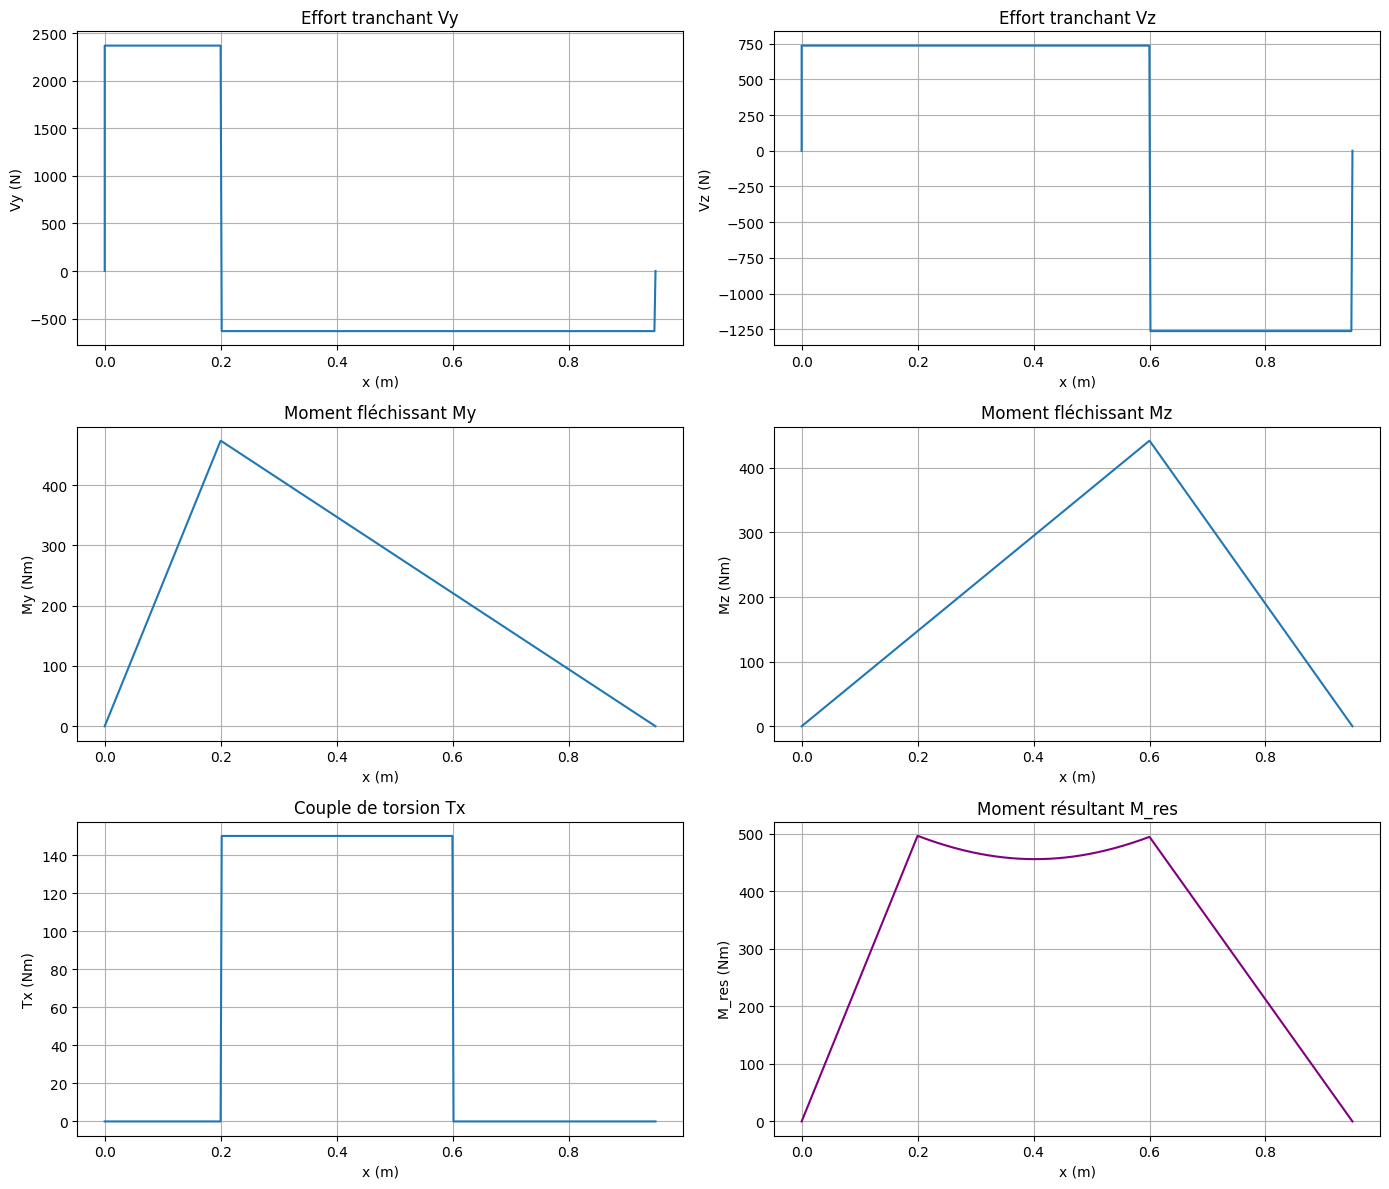

In [16]:
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

axes[0,0].plot(x_plot, Vy_plot)
axes[0,0].set(title='Effort tranchant Vy', xlabel='x (m)', ylabel='Vy (N)')
axes[0,0].grid()

axes[0,1].plot(x_plot, Vz_plot)
axes[0,1].set(title='Effort tranchant Vz', xlabel='x (m)', ylabel='Vz (N)')
axes[0,1].grid()

axes[1,0].plot(x_vals, My)
axes[1,0].set(title='Moment fléchissant My', xlabel='x (m)', ylabel='My (Nm)')
axes[1,0].grid()

axes[1,1].plot(x_vals, Mz)
axes[1,1].set(title='Moment fléchissant Mz', xlabel='x (m)', ylabel='Mz (Nm)')
axes[1,1].grid()

axes[2,0].plot(x_vals, Tx)
axes[2,0].set(title='Couple de torsion Tx', xlabel='x (m)', ylabel='Tx (Nm)')
axes[2,0].grid()

axes[2,1].plot(x_vals, M_res, color='purple')
axes[2,1].set(title='Moment résultant M_res', xlabel='x (m)', ylabel='M_res (Nm)')
axes[2,1].grid()

plt.tight_layout()
plt.show()


## Identification du point critique

Le point critique est déterminé comme étant celui où le moment résultant combiné (torsion et flexion) atteint sa valeur maximale entre les engrenages B et C.  
Cette position correspond à la contrainte maximale dans l’arbre.


In [6]:
# Identifier le point critique
idx_zone = (x_vals >= x_B) & (x_vals <= x_C)
idx_crit_local = np.argmax(M_res[idx_zone])
idx_crit = np.where(idx_zone)[0][0] + idx_crit_local

x_crit = x_vals[idx_crit]
M_crit = M_res[idx_crit]
T_crit = Tx[idx_crit]

print(f"Point critique : x = {x_crit:.3f} m, M_res = {M_crit:.2f} Nm, T = {T_crit:.2f} Nm")


Point critique : x = 0.202 m, M_res = 495.50 Nm, T = 150.04 Nm


## Contraintes au point critique

À partir des valeurs du moment résultant maximal et du couple de torsion, nous calculons :

- La contrainte normale maximale (**σ**) par flexion
- La contrainte de cisaillement maximale (**τ**) par torsion
- La contrainte équivalente de Von Mises (**σ_eq**)


In [7]:
sigma_max = M_crit * c / I
tau_torsion = T_crit * c / J

# Contraintes principales via Mohr
sigma_1 = sigma_max / 2 + np.sqrt((sigma_max / 2)**2 + tau_torsion**2)
sigma_2 = sigma_max / 2 - np.sqrt((sigma_max / 2)**2 + tau_torsion**2)

# Formule du manuel (Hibbeler, équation 10-30)
sigma_eq = np.sqrt(sigma_1**2 - sigma_1 * sigma_2 + sigma_2**2)

print("\nContraintes calculées (manuel Hibbeler):")
print(f"Contrainte normale (sigma): {sigma_max/1e6:.2f} MPa")
print(f"Contrainte de cisaillement (tau): {tau_torsion/1e6:.2f} MPa")
print(f"Sigma 1 (max): {sigma_1/1e6:.2f} MPa")
print(f"Sigma 2 (min): {sigma_2/1e6:.2f} MPa")
print(f"Contrainte équivalente (Von Mises - Hibbeler): {sigma_eq/1e6:.2f} MPa")



Contraintes calculées (manuel Hibbeler):
Contrainte normale (sigma): 186.93 MPa
Contrainte de cisaillement (tau): 28.30 MPa
Sigma 1 (max): 191.12 MPa
Sigma 2 (min): -4.19 MPa
Contrainte équivalente (Von Mises - Hibbeler): 193.25 MPa


## Cercle de Mohr – Contraintes principales

Le cercle de Mohr suivant permet de visualiser l'état plan de contraintes au point critique.  
Il permet d’obtenir directement les contraintes principales (σ₁, σ₂) et la contrainte maximale en cisaillement (rayon du cercle).


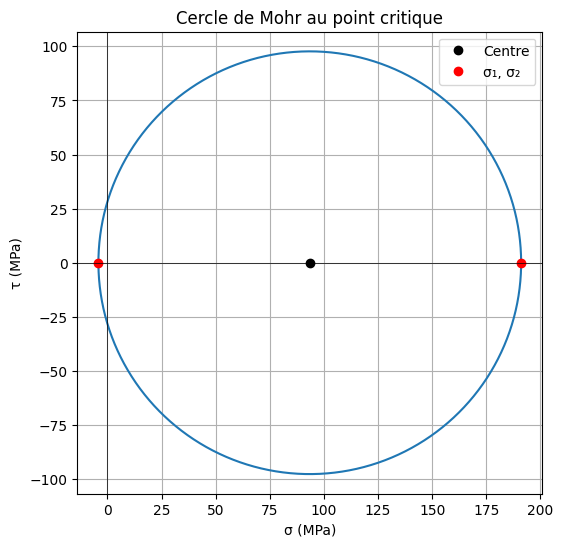


Contraintes principales (Cercle de Mohr):
Sigma 1 = 191.12 MPa
Sigma 2 = -4.19 MPa
Tau max (rayon R) = 97.66 MPa


In [9]:
sigma_avg = sigma_max / 2
R_mohr = np.sqrt((sigma_max / 2)**2 + tau_torsion**2)
theta = np.linspace(0, 2*np.pi, 360)

# Cercle de Mohr
plt.figure(figsize=(6,6))
plt.plot((sigma_avg + R_mohr*np.cos(theta))/1e6, (R_mohr*np.sin(theta))/1e6)
plt.plot([sigma_avg/1e6], [0], 'ko', label='Centre')
plt.plot([(sigma_avg + R_mohr)/1e6, (sigma_avg - R_mohr)/1e6], [0, 0], 'ro', label='σ₁, σ₂')

plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.xlabel('σ (MPa)')
plt.ylabel('τ (MPa)')
plt.title('Cercle de Mohr au point critique')
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.show()

print("\nContraintes principales (Cercle de Mohr):")
print(f"Sigma 1 = {sigma_1/1e6:.2f} MPa")
print(f"Sigma 2 = {sigma_2/1e6:.2f} MPa")
print(f"Tau max (rayon R) = {R_mohr/1e6:.2f} MPa")